# Triple Pendulum CHAOS!

*This, as well as the underlying pendulum implementation, is based on this post [post](http://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is MIT licensed.*

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import odeint


# FILE = "experiments/tmp/0-X_pred.npy"
N = 1
FILE = f"pendulum-cache/p-physics-{N}.npy"

data = np.load(FILE)
print(f"Loaded data: {data.shape}")

Loaded data: (1000, 1000, 2)


## Extracting Positions

The function above returns generalized coordinates, which in this case are the angular position and velocity of each pendulum segment, relative to vertical.
To visualize the pendulum, we need a quick utility to extract *x* and *y* coordinates from these angular coordinates:

In [97]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

Finally, we can call this function to plot the movement of a pendulum over time:

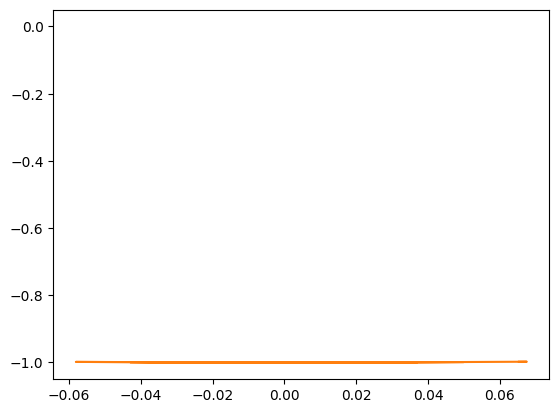

In [98]:
selected_data = data[:,8,:]
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

And here are the positions of a triple pendulum over time:

In [99]:
from models import pendulum_energy
import torch
energy_func = pendulum_energy.pendulum_energy(N)

In [100]:
from importlib import reload
pendulum_energy = reload(pendulum_energy)
energy_func = pendulum_energy.pendulum_energy(N)

In [101]:
def getEnergyViolations(selected_data):
    """Get energy and violations for each timestep"""
    energy = energy_func(torch.tensor(selected_data)).numpy()
    
    violations = []
    p_e = 999999
    for i, e in enumerate(energy):
        if p_e < e:
            violations.append(i)
        p_e = e

    return energy, violations

In [102]:
print(selected_data.shape)

(1000, 2)


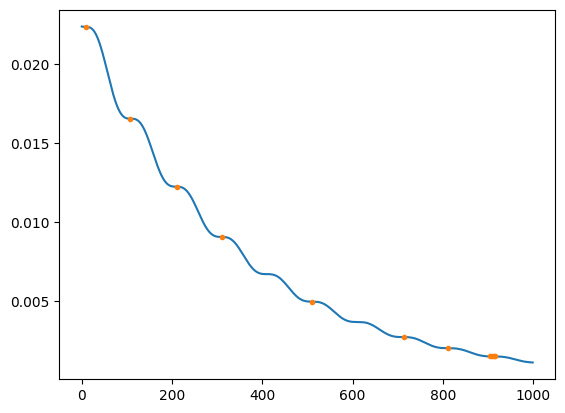

In [103]:
energy, violations = getEnergyViolations(selected_data)
plt.plot(range(len(energy)), energy)
plt.plot(violations, [energy[v] for v in violations], '.')

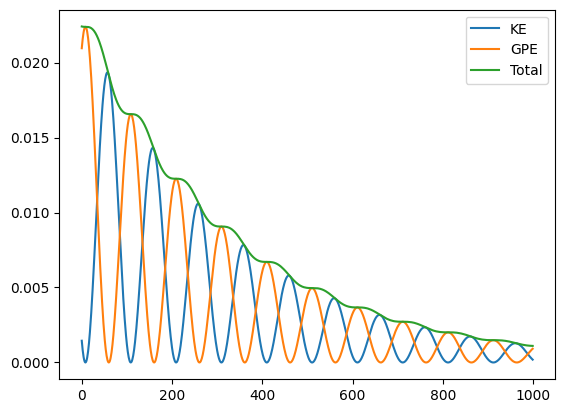

In [104]:
energy = pendulum_energy.pendulum_energy(N)
ke_func = pendulum_energy.pendulum_energy(N, include_gpe=False, include_ke=True)
gpe_func = pendulum_energy.pendulum_energy(N, include_gpe=True, include_ke=False)
energy     = energy_func(torch.tensor(selected_data)).numpy()
energy_ke  =     ke_func(torch.tensor(selected_data)).numpy()
energy_gpe =    gpe_func(torch.tensor(selected_data)).numpy()
plt.plot(range(len(energy_ke)), energy_ke)
plt.plot(range(len(energy_gpe)), energy_gpe)

violations = []
p_e = 999999
for i, e in enumerate(energy):
    if p_e < e:
        violations.append(i)
    p_e = e

plt.plot(range(len(energy)), energy)
# plt.plot(violations, [energy[v] for v in violations], '.')
plt.legend(["KE", "GPE", "Total"])

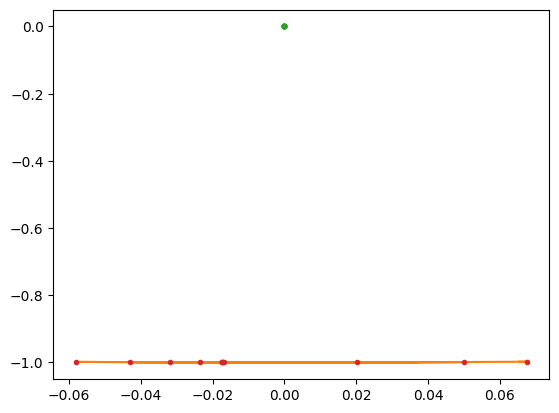

In [105]:
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

v_coords = [coords for i, coords in enumerate(zip(x, y)) if i in violations]
plt.plot(*zip(*v_coords), '.')
None

## Pendulum Animations

The static plots above provide a bit of insight into the situation, but it's much more intuitive to see the results as an animation.
Drawing from the double pendulum code in my [Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), here is a function to animate the pendulum's motion over time:

In [106]:
from matplotlib import animation


def animate_pendulum(selected_data, energy=None, violations=None, fps=30):
    x, y = get_xy_coords(selected_data)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)
    title = ax.text(0.5,0.5, "", bbox={'facecolor':'k', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")
    
    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        if energy is not None:
            pass
            title.set_text(f"Energy {energy[i]}")
        line.set_data(x[i], y[i])
        if violations is not None and i in violations:
            line.set_color('r')
        else:
            line.set_color('b')
            
        return line, title

    anim = animation.FuncAnimation(fig, animate, frames=x.shape[0],
                                   interval=1/fps*1000,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

###  Comparing results of predictions and actuals:

In [107]:
# Timestep, X, values
m, m_i = 0, -1
for i in range(4, physics.shape[1]):
    first_ang_pos = physics[0][i][0]
    if first_ang_pos < m:
        m = first_ang_pos
        m_i = i
print(m, m_i)

chosen_traj = m_i + 10 #np.random.randint(1000) 
fps=30
chosen_traj

-1.5706474 547


557

Predicted behaviour (simple 2-link)

In [108]:
predicted_simp = np.load(f"experiments/error_simple/{N}/1_pred.npy")
print(f"Loaded data: {predicted_simp.shape}")
chosen_run = np.random.randint(predicted_simp.shape[0])
print(chosen_run)

selected_pred_simp = predicted_simp[chosen_run,:,chosen_traj,:]
e, v = getEnergyViolations(selected_pred_simp) # violations are times where the total energy in the system increases
anim = animate_pendulum(selected_pred_simp, e, v, fps=fps)
HTML(anim.to_html5_video())  # uncomment to embed

Loaded data: (2, 1000, 1000, 2)
0


Predicted behaviour (stable 2-link)

In [111]:
predicted_stab = np.load(f"experiments/error_stable/{N}/0.001_PSD-REHU_0.01_0_0.005/2_pred.npy")
chosen_run = np.random.randint(predicted_stab.shape[0])
print(chosen_run)

selected_pred_stab = predicted_stab[chosen_run,:,chosen_traj,:]
e, v = getEnergyViolations(selected_pred_stab) # violations are times where the total energy in the system increases
anim = animate_pendulum(selected_pred_stab, e, v, fps=fps)
HTML(anim.to_html5_video())  # uncomment to embed

0


Actual behavior (as per p-physics)

In [112]:
physics = np.load(f"pendulum-cache/p-physics-{N}.npy")
selected_phy = physics[:,chosen_traj,:]
print(selected_phy.shape)
e, v = getEnergyViolations(selected_phy)
anim = animate_pendulum(selected_phy, e, v, fps=fps)
HTML(anim.to_html5_video())

(1000, 2)


In [ ]:
# selected_phy[0] = [-0.9,  1.34545460e-01,  1.62435472e-01,  3.55527699e-01]
# print(selected_phy.shape)
# e, v = getEnergyViolations(selected_phy)
# anim = animate_pendulum(selected_phy, e, v, fps=fps)
# HTML(anim.to_html5_video())

In [ ]:
print(selected_phy)

[[ 0.17122163  0.6224324  -0.5230813  -0.33499974]
 [ 0.16615978  0.6183767  -0.4893258  -0.47570202]
 [ 0.1614344   0.6129276  -0.45578822 -0.6136304 ]
 ...
 [-0.01908014 -0.024494   -0.03420906 -0.05929106]
 [-0.01941029 -0.02507114 -0.03181591 -0.05612919]
 [-0.01971638 -0.02561642 -0.02939864 -0.05291958]]


In [ ]:
errors = np.load("experiments/error_stable/2/0.001_PSD-REHU_0.01_0_0.001/1.npy")

# Verify errors


In [ ]:
print(f"pendulum-cache/p-physics-{predicted_simp.shape[-1]//2}.npy")

pendulum-cache/p-physics-2.npy


In [ ]:
physics.shape

(1000, 1000, 4)